In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.applications import VGG16
from keras.applications import ResNet101

from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [33]:
train_path = './Data Main/train'
test_path = './Data Main/test'
val_path = './Data Main/val'

In [34]:

train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [35]:
size_images = 150
batch_size = 32

In [36]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

Found 31571 images belonging to 4 classes.


In [37]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [38]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 6769 images belonging to 4 classes.


In [39]:
val_datagen = ImageDataGenerator(rescale=1.0/255)

In [40]:

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 6765 images belonging to 4 classes.


In [41]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import math

# Build DenseNet-121 model
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

# Create a new model
model = Sequential()
model.add(densenet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(4, activation='softmax'))  # Assuming num_classes is the number of your classes

# Freeze the layers of the pre-trained model
for layer in densenet_model.layers:
    layer.trainable = False

# Define a learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

# Compile the model with an initial learning rate
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Use the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping, lr_callback]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 256)               262400    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                      

In [42]:
# Save the model
model.save('densenet121_model.h5')

/home/aiworkstation1/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
# Evaluate the model on the test set
test_results = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

211/211 [==============================] - 129s 608ms/step - loss: 0.1128 - accuracy: 0.9618
Test Loss: 0.11281687021255493
Test Accuracy: 0.961789071559906


In [68]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('densenet121_model.h5')

# Create a test generator for the test set
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important to keep the order for evaluation
)

# Initialize lists to accumulate predictions and true labels
all_predictions = []
all_true_labels = []

# Loop through all batches in the test generator
for _ in range(len(test_generator)):
    images, labels = test_generator.next()

    # Predictions on the current batch
    batch_predictions = loaded_model.predict(images)
    all_predictions.extend(batch_predictions)
    
    # True labels for the current batch
    batch_true_labels = np.argmax(labels, axis=1)
    all_true_labels.extend(batch_true_labels)

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Extract predicted labels from all predictions
predicted_labels = np.argmax(all_predictions, axis=1)




Found 6769 images belonging to 4 classes.
1/1 [==============================] - 5s 5s/step


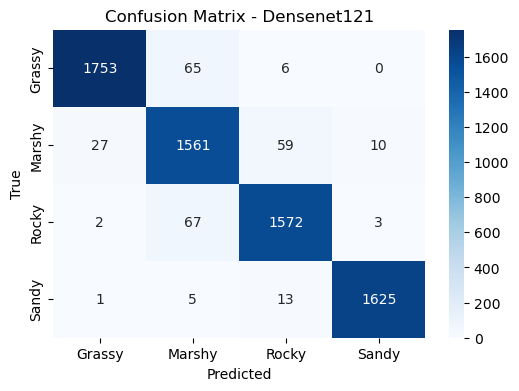

In [66]:
# Confusion Matrix
conf_mat = confusion_matrix(all_true_labels, predicted_labels)

# Plot the confusion matrix
class_names = ['Grassy', 'Marshy', 'Rocky', 'Sandy']  # Update with your actual class names
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Densenet121')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [72]:
# Classification Report
print("Classification Report of DenseNet121:")
print(classification_report(all_true_labels, predicted_labels, target_names=class_names))

Classification Report of DenseNet121:
              precision    recall  f1-score   support

      Grassy       0.98      0.96      0.97      1824
      Marshy       0.92      0.94      0.93      1657
       Rocky       0.95      0.96      0.95      1644
       Sandy       0.99      0.99      0.99      1644

    accuracy                           0.96      6769
   macro avg       0.96      0.96      0.96      6769
weighted avg       0.96      0.96      0.96      6769



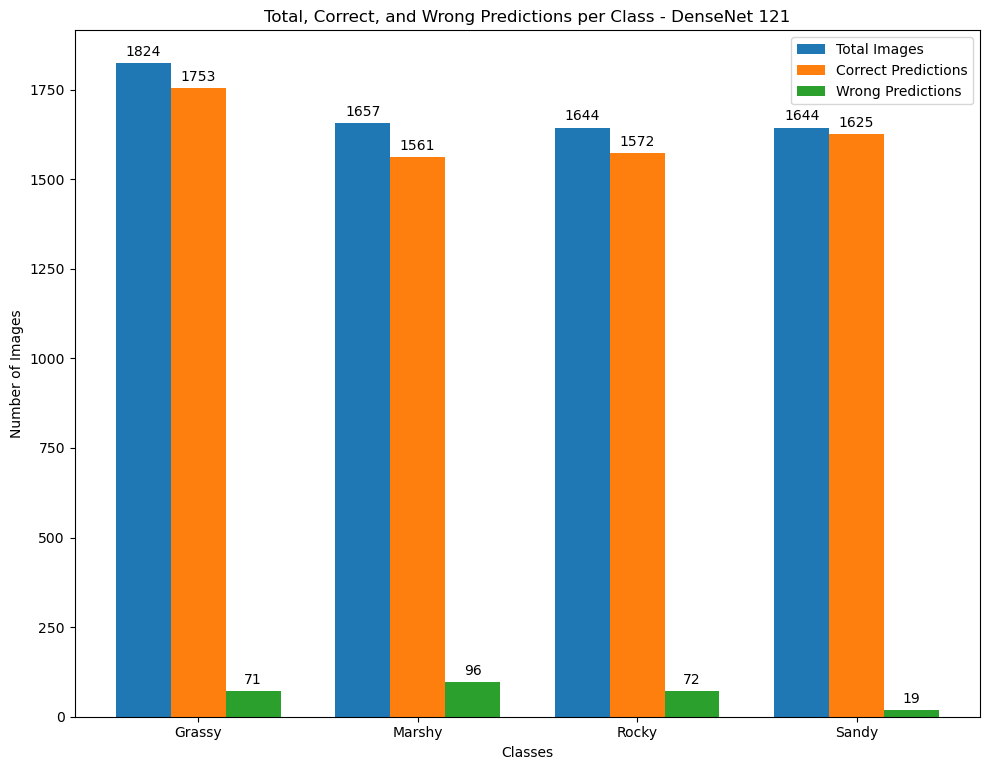

In [71]:
class_names = ['Grassy', 'Marshy', 'Rocky', 'Sandy']  # Update with your actual class names

# Print the number of images classified correctly and wrongly in each class
correctly_classified = np.diag(conf_mat)
wrongly_classified = np.sum(conf_mat, axis=1) - correctly_classified

# Total number of images in each class
total_images_per_class = np.sum(conf_mat, axis=1)

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, total_images_per_class, width, label='Total Images')
rects2 = ax.bar(x, correctly_classified, width, label='Correct Predictions')
rects3 = ax.bar(x + width, wrongly_classified, width, label='Wrong Predictions')

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Total, Correct, and Wrong Predictions per Class - DenseNet 121')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Display the number of images on top of each bar with proper spacing
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 1.3])  # Increase the value in the last argument if necessary

plt.show()

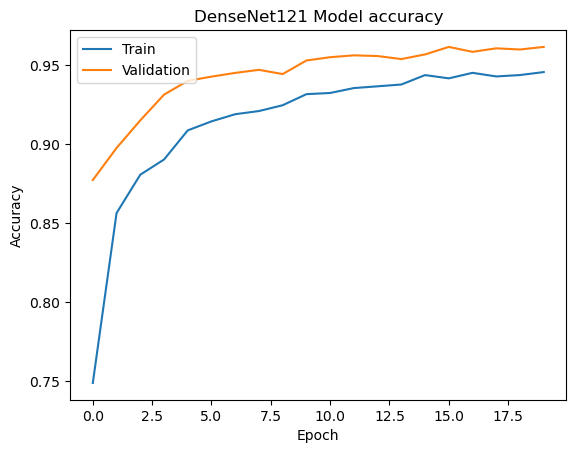

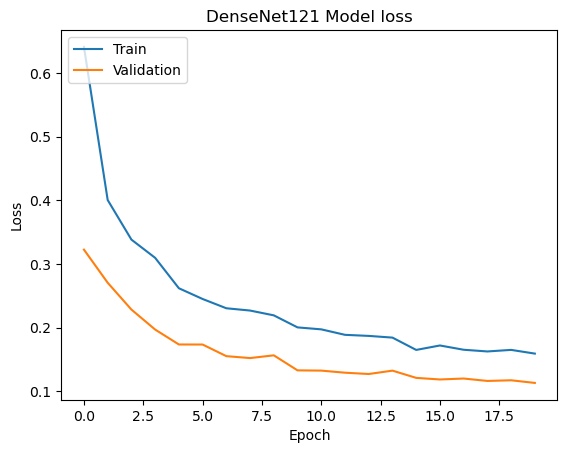

In [70]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object you get after training your DenseNet model
# Replace 'history' with the actual variable name you have

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DenseNet121 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DenseNet121 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
